# Import Required Libraries
Import the necessary libraries, such as requests, for making API calls.

In [37]:
#%pip install import-ipynb
import import_ipynb
from Stock_Reserach import *
import requests
import pandas as pd
import datetime as dt
import os
from textblob import TextBlob
from transformers import pipeline


In [7]:
API_Eodhd = "66c0aeb1357b15.87356825"

# Creating a backtesting engine (EMA)
Creating a backtesting engine for exponential moving average

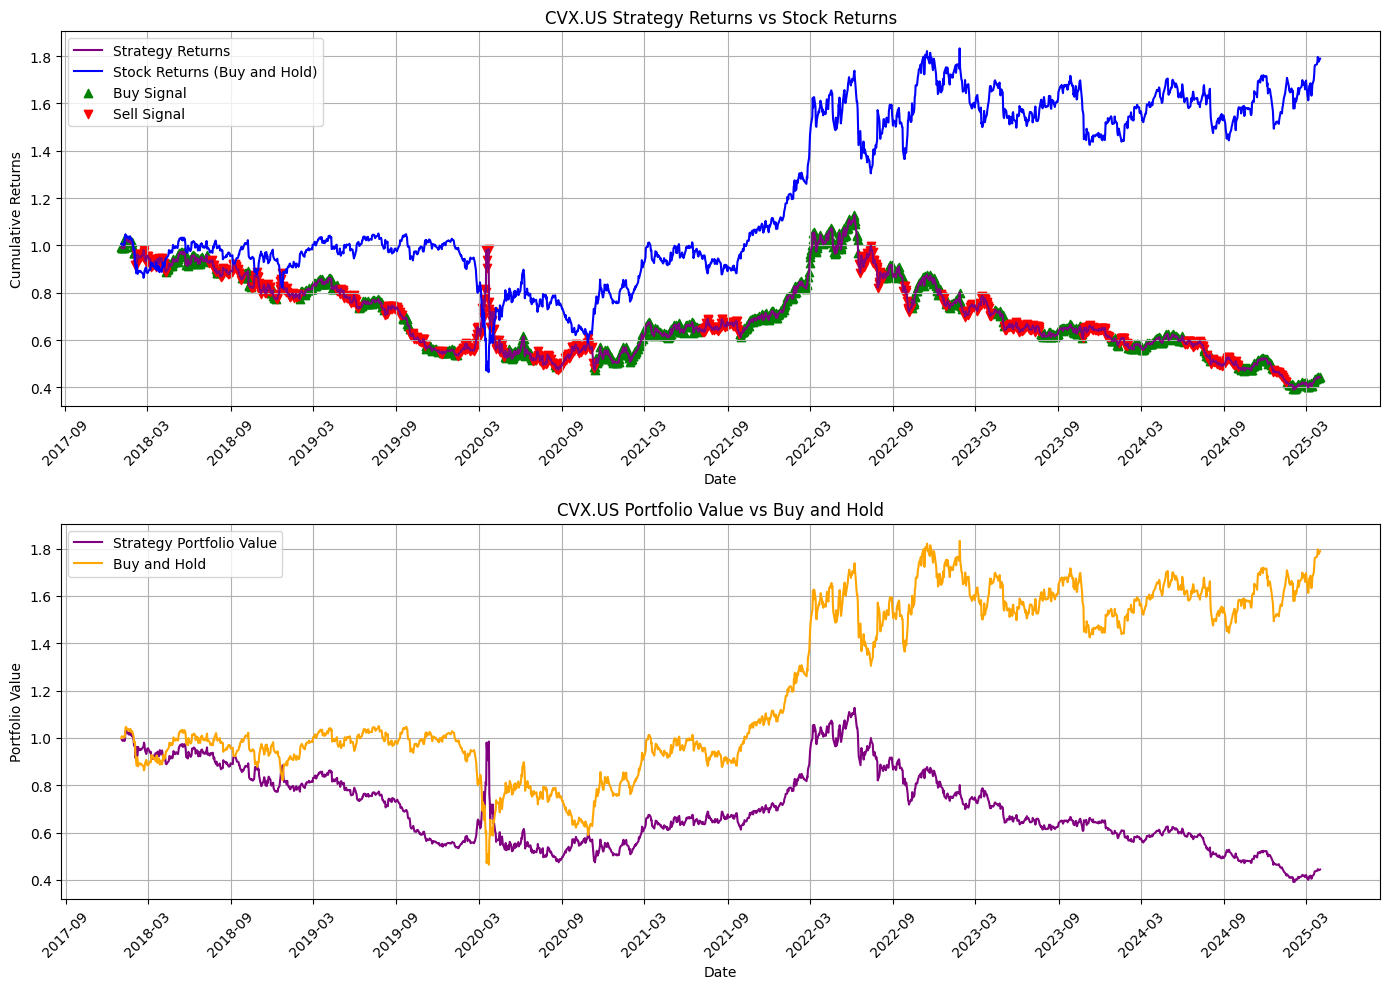

Total Return: -0.5558151629351531
Volatility: 0.31884000573865123
Max Drawdown: -0.6525769796155606


In [23]:
import matplotlib.dates as mdates

def backtest_ema_strategy(stock, start_date, end_date, api_token=API_Eodhd, short_window=20, long_window=30):
    """
    Backtest a strategy that buys a stock when the short-term EMA (20 days) is higher than the long-term EMA (30 days)
    and sells it when the short-term EMA is lower than the long-term EMA. Also plots the strategy returns vs stock returns
    and includes buy/sell signals. Compares the portfolio value with a buy-and-hold strategy.

    Parameters:
        stock (str): The stock symbol (e.g., "AAPL.US").
        start_date (str): The start date for the backtest in "YYYY-MM-DD" format.
        end_date (str): The end date for the backtest in "YYYY-MM-DD" format.
        api_token (str): API token for fetching historical prices.
        short_window (int): The number of days for the short-term EMA (default: 20).
        long_window (int): The number of days for the long-term EMA (default: 30).

    Returns:
        dict: A dictionary containing the backtest results, performance metrics, and the DataFrame.
    """
    # Fetch historical stock prices
    stock_data = Fetch_historical_price(stock, start_date, end_date, "d", api_token, columns=["adjusted_close"])
    
    # Ensure the data is sorted by date
    stock_data["date"] = pd.to_datetime(stock_data["date"])
    stock_data = stock_data.sort_values(by="date")
    
    # Calculate short-term and long-term EMAs
    stock_data["EMA_short"] = stock_data["adjusted_close"].ewm(span=short_window, adjust=False).mean()
    stock_data["EMA_long"] = stock_data["adjusted_close"].ewm(span=long_window, adjust=False).mean()
    
    # Generate buy/sell signals
    stock_data["Signal"] = 0  # Default to no position
    stock_data.loc[stock_data["EMA_short"] > stock_data["EMA_long"], "Signal"] = 1  # Buy signal
    stock_data.loc[stock_data["EMA_short"] <= stock_data["EMA_long"], "Signal"] = -1  # Sell signal
    
    # Calculate daily returns and portfolio value
    stock_data["Daily_Return"] = stock_data["adjusted_close"].pct_change()
    stock_data["Strategy_Return"] = stock_data["Signal"].shift(1) * stock_data["Daily_Return"]
    stock_data["Portfolio_Value"] = (1 + stock_data["Strategy_Return"]).cumprod()
    stock_data["Stock_Return"] = (1 + stock_data["Daily_Return"]).cumprod()
    
    # Calculate buy-and-hold portfolio value
    stock_data["Buy_and_Hold"] = stock_data["adjusted_close"] / stock_data["adjusted_close"].iloc[0]
    
    # Calculate performance metrics
    total_return = stock_data["Portfolio_Value"].iloc[-1] - 1
    volatility = stock_data["Strategy_Return"].std() * np.sqrt(252)  # Annualized volatility
    drawdown = (stock_data["Portfolio_Value"] / stock_data["Portfolio_Value"].cummax()) - 1
    max_drawdown = drawdown.min()
    
    # Plot the results
    plt.figure(figsize=(14, 10))
    
    # Plot strategy returns vs stock returns with buy/sell signals
    plt.subplot(2, 1, 1)
    plt.plot(stock_data["date"], stock_data["Portfolio_Value"], label="Strategy Returns", color="purple")
    plt.plot(stock_data["date"], stock_data["Stock_Return"], label="Stock Returns (Buy and Hold)", color="blue")
    
    # Highlight buy and sell signals
    buy_signals = stock_data[stock_data["Signal"] == 1]
    sell_signals = stock_data[stock_data["Signal"] == -1]
    plt.scatter(buy_signals["date"], buy_signals["Portfolio_Value"], label="Buy Signal", marker="^", color="green", alpha=1)
    plt.scatter(sell_signals["date"], sell_signals["Portfolio_Value"], label="Sell Signal", marker="v", color="red", alpha=1)
    
    plt.title(f"{stock} Strategy Returns vs Stock Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format x-axis labels as "YYYY-MM"
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show ticks every 6 months
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    # Plot buy-and-hold vs portfolio value without buy/sell signals
    plt.subplot(2, 1, 2)
    plt.plot(stock_data["date"], stock_data["Portfolio_Value"], label="Strategy Portfolio Value", color="purple")
    plt.plot(stock_data["date"], stock_data["Buy_and_Hold"], label="Buy and Hold", color="orange")
    
    plt.title(f"{stock} Portfolio Value vs Buy and Hold")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format x-axis labels as "YYYY-MM"
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show ticks every 6 months
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()
    
    # Return results and metrics
    return {
        "DataFrame": stock_data,
        "Total_Return": total_return,
        "Volatility": volatility,
        "Max_Drawdown": max_drawdown
    }

# Example usage
stock = "CVX.US"
start_date = "2018-01-01"
end_date = "2025-04-01"

results = backtest_ema_strategy(stock, start_date, end_date)

# Print performance metrics
print("Total Return:", results["Total_Return"])
print("Volatility:", results["Volatility"])
print("Max Drawdown:", results["Max_Drawdown"])

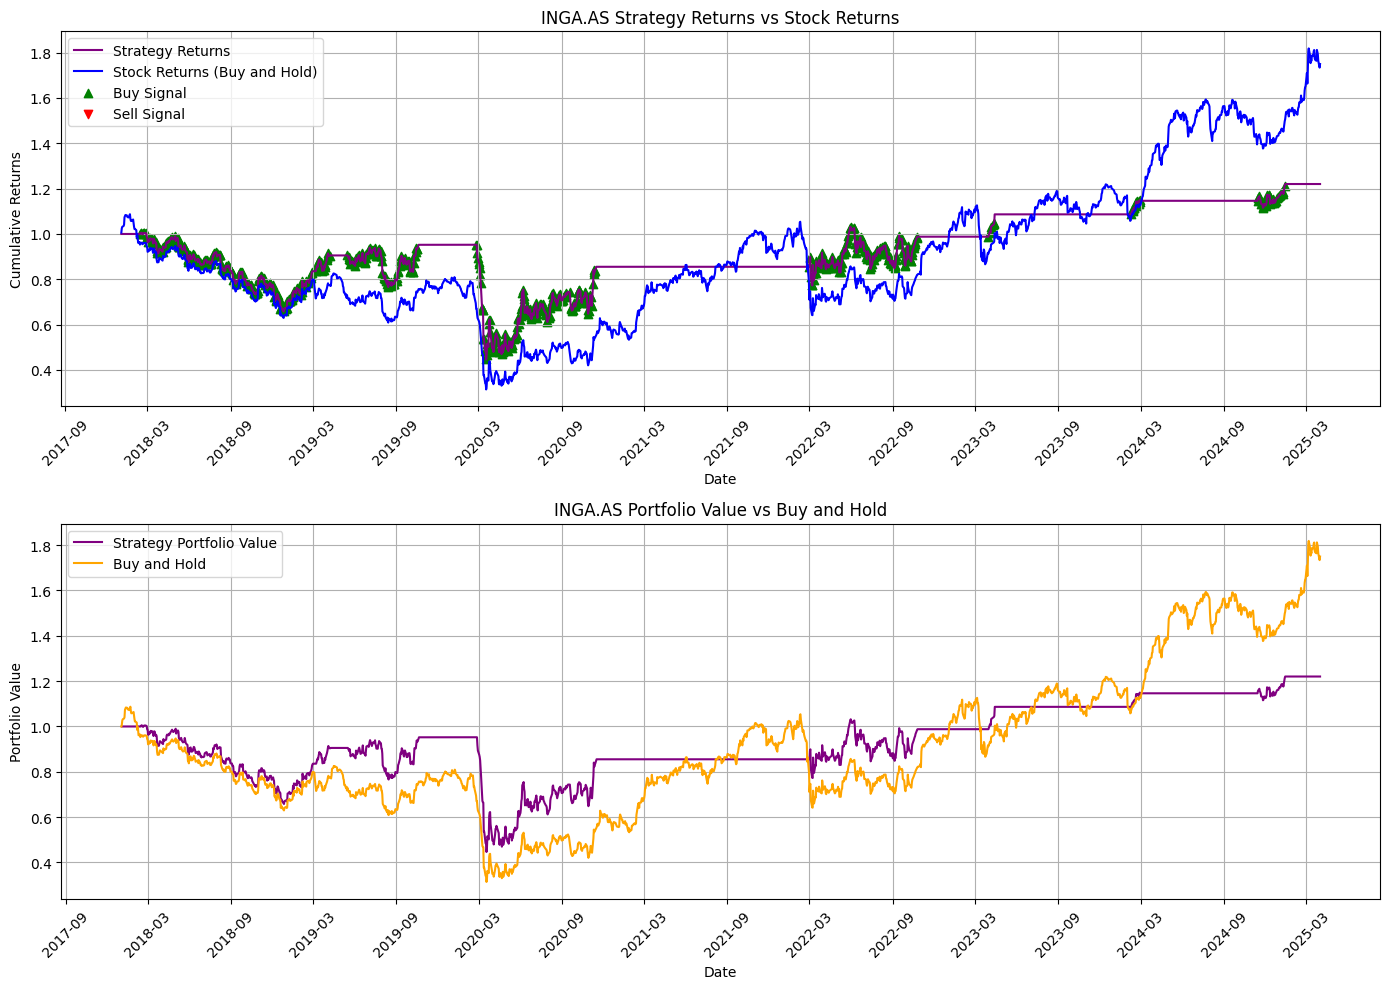

Total Return: 0.22034885685579852
Buy and Hold Return: 0.7496144949884349
Volatility: 0.27539572755049263
Max Drawdown: -0.5559898957884953


In [32]:
import matplotlib.dates as mdates

def backtest_ema_strategy(stock, start_date, end_date, api_token=API_Eodhd, short_window=150, long_window=20):
    """
    Backtest a strategy that buys a stock when the short-term EMA (20 days) is higher than the long-term EMA (30 days)
    and sells it when the short-term EMA is lower than the long-term EMA. Also plots the strategy returns vs stock returns
    and includes buy/sell signals. Compares the portfolio value with a buy-and-hold strategy.

    Parameters:
        stock (str): The stock symbol (e.g., "AAPL.US").
        start_date (str): The start date for the backtest in "YYYY-MM-DD" format.
        end_date (str): The end date for the backtest in "YYYY-MM-DD" format.
        api_token (str): API token for fetching historical prices.
        short_window (int): The number of days for the short-term EMA (default: 20).
        long_window (int): The number of days for the long-term EMA (default: 30).

    Returns:
        dict: A dictionary containing the backtest results, performance metrics, and the DataFrame.
    """
    # Fetch historical stock prices
    stock_data = Fetch_historical_price(stock, start_date, end_date, "d", api_token, columns=["adjusted_close"])
    
    # Ensure the data is sorted by date
    stock_data["date"] = pd.to_datetime(stock_data["date"])
    stock_data = stock_data.sort_values(by="date")
    
    # Calculate short-term and long-term EMAs
    stock_data["EMA_short"] = stock_data["adjusted_close"].ewm(span=short_window, adjust=False).mean()
    stock_data["EMA_long"] = stock_data["adjusted_close"].ewm(span=long_window, adjust=False).mean()
    
    # Generate buy/sell signals
    stock_data["Signal"] = 0  # Default to no position
    stock_data.loc[stock_data["EMA_short"] > stock_data["EMA_long"], "Signal"] = 1  # Buy signal
    stock_data.loc[stock_data["EMA_short"] <= stock_data["EMA_long"], "Signal"] = -1  # Sell signal
    
    # Ensure stock_data values never go negative
    stock_data["adjusted_close"] = stock_data["adjusted_close"].clip(lower=0)
    stock_data["EMA_short"] = stock_data["EMA_short"].clip(lower=0)
    stock_data["EMA_long"] = stock_data["EMA_long"].clip(lower=0)
    
    # Ensure sell signals do not reduce stock values to negative
    stock_data["Signal"] = stock_data["Signal"].clip(lower=0)
    # Calculate daily returns and portfolio value
    stock_data["Daily_Return"] = stock_data["adjusted_close"].pct_change()
    stock_data["Strategy_Return"] = stock_data["Signal"].shift(1) * stock_data["Daily_Return"]
    stock_data["Portfolio_Value"] = (1 + stock_data["Strategy_Return"]).cumprod()
    stock_data["Stock_Return"] = (1 + stock_data["Daily_Return"]).cumprod()
    
    # Calculate buy-and-hold portfolio value
    stock_data["Buy_and_Hold"] = stock_data["adjusted_close"] / stock_data["adjusted_close"].iloc[0]
    
    # Calculate performance metrics
    total_return = stock_data["Portfolio_Value"].iloc[-1] - 1
    volatility = stock_data["Strategy_Return"].std() * np.sqrt(252)  # Annualized volatility
    drawdown = (stock_data["Portfolio_Value"] / stock_data["Portfolio_Value"].cummax()) - 1
    max_drawdown = drawdown.min()
    
    # Plot the results
    plt.figure(figsize=(14, 10))
    
    # Plot strategy returns vs stock returns with buy/sell signals
    plt.subplot(2, 1, 1)
    plt.plot(stock_data["date"], stock_data["Portfolio_Value"], label="Strategy Returns", color="purple")
    plt.plot(stock_data["date"], stock_data["Stock_Return"], label="Stock Returns (Buy and Hold)", color="blue")
    
    # Highlight buy and sell signals
    buy_signals = stock_data[stock_data["Signal"] == 1]
    sell_signals = stock_data[stock_data["Signal"] == -1]
    plt.scatter(buy_signals["date"], buy_signals["Portfolio_Value"], label="Buy Signal", marker="^", color="green", alpha=1)
    plt.scatter(sell_signals["date"], sell_signals["Portfolio_Value"], label="Sell Signal", marker="v", color="red", alpha=1)
    
    plt.title(f"{stock} Strategy Returns vs Stock Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.grid()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format x-axis labels as "YYYY-MM"
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show ticks every 6 months
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    # Plot buy-and-hold vs portfolio value without buy/sell signals
    plt.subplot(2, 1, 2)
    plt.plot(stock_data["date"], stock_data["Portfolio_Value"], label="Strategy Portfolio Value", color="purple")
    plt.plot(stock_data["date"], stock_data["Buy_and_Hold"], label="Buy and Hold", color="orange")
    
    plt.title(f"{stock} Portfolio Value vs Buy and Hold")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format x-axis labels as "YYYY-MM"
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show ticks every 6 months
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()
    
    # Return results and metrics
    return {
        "DataFrame": stock_data,
        "Total_Return": total_return,
        "Buy_hold_Return": stock_data["Buy_and_Hold"].iloc[-1] - 1,
        "Volatility": volatility,
        "Max_Drawdown": max_drawdown
    }

# Example usage
stock = "INGA.AS"
start_date = "2018-01-01"
end_date = "2025-04-01"

results = backtest_ema_strategy(stock, start_date, end_date)

# Print performance metrics
print("Total Return:", results["Total_Return"])
print("Buy and Hold Return:", results["Buy_hold_Return"])
print("Volatility:", results["Volatility"])
print("Max Drawdown:", results["Max_Drawdown"])


# Creating a strategy test using live data
Creating a strategy test in which it compares intraday data with with 20 day EMA every interval for specified duration

In [48]:
import time
import pandas as pd

def fetch_intraday_data(stock, api_token= API_Eodhd):
    """
    Fetch intraday data for a given stock from the EODHD API and convert it to a Pandas DataFrame.

    Parameters:
        stock (str): The stock symbol (e.g., "AAPL.US").
        api_token (str): Your API token for authentication.
        interval (str): The interval for intraday data (e.g., "1m", "5m", "15m", "1h"). Default is "1m".

    Returns:
        pd.DataFrame: A DataFrame containing the intraday data.
    """
    url = f'https://eodhd.com/api/intraday/{stock}?api_token={api_token}&fmt=json'
    response = requests.get(url)
    
    # Parse the JSON response
    data = response.json()
    
    # Convert JSON to Pandas DataFrame
    df = pd.DataFrame(data)
    
    # Ensure the 'datetime' column is in datetime format
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df


def compare_intraday_with_ema(stock, api_token=API_Eodhd, duration=20, interval_seconds=5):
    """
    Recursively fetch intraday data every 20 seconds for 2 minutes and compare it with the 20-day EMA.

    Parameters:
        stock (str): The stock symbol (e.g., "AAPL.US").
        api_token (str): Your API token for authentication.
        interval (str): The interval for intraday data (default: "1m").
        duration (int): Total duration to run the function in seconds (default: 120 seconds).
        interval_seconds (int): Interval between recursive calls in seconds (default: 20 seconds).

    Returns:
        None: Prints the comparison of intraday prices with the EMA.
    """
    # Fetch historical data to calculate the 20-day EMA
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    start_date = (pd.Timestamp.now() - pd.Timedelta(days=30)).strftime('%Y-%m-%d')
    historical_data = Fetch_historical_price(stock, start_date, end_date, api_token, columns=["adjusted_close"])
    historical_data['EMA_20'] = historical_data['adjusted_close'].ewm(span=20, adjust=False).mean()
    ema_20 = historical_data['EMA_20'].iloc[-1]  # Get the latest 20-day EMA (constant value)

    print(f"Constant EMA (20-day): {ema_20}\n")  # Display the constant EMA value

    # Recursive function to fetch intraday data and compare
    def recursive_fetch(duration):
        # Fetch intraday data
        intraday_data = fetch_intraday_data(stock, api_token).iloc[:1]  # Get the latest data point
        # Compare intraday prices with the constant 20-day EMA
        intraday_data['Comparison'] = intraday_data['close'].apply(lambda x: 'Greater' if x > ema_20 else 'Lower')

        # Display the comparison
        print(intraday_data[['datetime', 'close', 'Comparison']])

        # Stop recursion after the duration is complete
        duration -= interval_seconds
        if duration > 0:
            time.sleep(interval_seconds)
            recursive_fetch(duration)

    # Start the recursive process
    recursive_fetch(duration)


# Example usage
stock = "AAPL.US"
compare_intraday_with_ema(stock)

Constant EMA (20-day): 222.78652912739116

             datetime       close Comparison
0 2024-12-03 14:30:00  239.565002    Greater
             datetime       close Comparison
0 2024-12-03 14:30:00  239.565002    Greater
             datetime       close Comparison
0 2024-12-03 14:30:00  239.565002    Greater
             datetime       close Comparison
0 2024-12-03 14:30:00  239.565002    Greater


In [ ]:
import threading

# Define threads for running the tests simultaneously
thread1 = threading.Thread(target=compare_intraday_with_ema, args=("IUSA.AS",), kwargs={"duration": 1200, "interval_seconds": 1})
thread2 = threading.Thread(target=compare_intraday_with_ema, args=("IJPN.AS",), kwargs={"duration": 1200, "interval_seconds": 1})

# Start both threads
thread1.start()
thread2.start()

# Wait for both threads to complete
thread1.join()
thread2.join()

print("Both tests completed.")

Constant EMA (20-day): 52.519213318640496

Constant EMA (20-day): 16.515300051013654

             datetime      close Comparison
0 2024-12-03 08:00:00  17.163999    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  57.453998    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  17.163999    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  57.453998    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  17.163999    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  57.453998    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  17.163999    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  57.453998    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  17.163999    Greater
             datetime      close Comparison
0 2024-12-03 08:00:00  57.453998    Greater
             datetime      close C